# RideWise: Customer Analytics & Churn Prediction

This project focused on building a **customer analytics and churn prediction engine** for RideWise, a leading European mobility technology company. With over 200,000 customers and 800,000 monthly trips across major cities, RideWise faces a **25% quarterly churn challenge** that impacts revenue and growth.  

The project integrates **customer segmentation, churn modeling, and real-time analytics** to deliver proactive retention strategies. Using Python, scikit-learn, FastAPI, and Streamlit, the solution provides:

- **Churn Prediction**: Identifying at-risk users before they leave.  
- **Customer Segmentation**: Tailoring retention strategies for commuters, occasional users, and weekend riders.  
- **Real-time Insights**: API-driven risk scoring and dashboards for instant decision-making.  

This notebook serves as the foundation for exploring the datasets, implementing machine learning models, and demonstrating how data-driven insights can reduce churn, increase customer lifetime value, and optimize marketing spend.


In [4]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Importing required libraries for RideWise Customer Analytics & Churn Prediction

In [5]:
# Data manipulation & analysis
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Machine learning models & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Data Ingestion: Loading RideWise datasets

In [6]:
# Customers dataset: demographics and signup details
riders_df = pd.read_csv('../data/raw_data/riders.csv')

# Trips dataset: journey paths and payment information
trips_df = pd.read_csv('../data/raw_data/trips.csv')

# Behavior dataset: monthly aggregated metrics (RFM analysis)
drivers_df = pd.read_csv('../data/raw_data/drivers.csv')

# Promotions dataset: campaign usage and effectiveness
promotions_df = pd.read_csv('../data/raw_data/promotions.csv')

# External data: weather, holidays, competitor activity
sessions_df = pd.read_csv('../data/raw_data/sessions.csv')

# Quick overview of loaded datasets
print("Riders:", riders_df.shape)
print("Trips:", trips_df.shape)
print("Drivers:", drivers_df.shape)
print("Promotions:", promotions_df.shape)
print("Sessions:", sessions_df.shape)


Riders: (10000, 8)
Trips: (200000, 16)
Drivers: (5000, 7)
Promotions: (20, 11)
Sessions: (50000, 8)


**trips dataframe**

In [7]:
trips_df.head(2)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,weather,city,loyalty_status
0,T000000,R05207,D00315,12.11,1.0,0.00,Card,2024-11-27 18:41:50+02:27,2024-11-27 19:33:50+02:27,-1.108123,36.912209,-1.068155,36.875377,Foggy,Nairobi,Bronze
1,T000001,R09453,D03717,8.73,1.0,0.02,Card,2024-10-28 23:13:48+00:14,2024-10-28 23:26:48+00:14,6.675266,3.515740,6.641734,3.525620,Sunny,Lagos,Gold


In [8]:
trips_df[trips_df['user_id'] == 'R00000'].head(3)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,weather,city,loyalty_status
1144,T001144,R00000,D03414,23.62,1.4,0.00,Card,2024-09-04 00:56:02+02:27,2024-09-04 01:22:02+02:27,-1.115239,36.805339,-1.136842,36.793631,Rainy,Nairobi,Bronze
22441,T022441,R00000,D04441,16.31,1.0,0.00,Card,2025-04-02 17:13:29+02:27,2025-04-02 17:19:29+02:27,-1.350546,36.745210,-1.339873,36.770102,Sunny,Nairobi,Bronze
24771,T024771,R00000,D00635,9.66,1.0,0.03,Card,2024-05-23 09:37:47+02:27,2024-05-23 10:33:47+02:27,-1.316560,36.687127,-1.310676,36.680729,Sunny,Nairobi,Bronze


**riders dataframe**

In [9]:
riders_df.head(2)

,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,NaN


**drivers dataframe**

In [10]:
drivers_df.head(2)

,driver_id,rating,vehicle_type,signup_date,last_active,city,acceptance_rate
0,D00000,3.1,SUV,2025-01-20,2025-01-06 18:23:09.312275,Cairo,0.679555
1,D00001,5.0,Sedan,2023-03-27,2025-04-27 01:44:02.472554,Nairobi,0.548786


**sessions dataframe**

In [11]:
sessions_df.head(2)

,session_id,rider_id,session_time,time_on_app,pages_visited,converted,city,loyalty_status
0,S000000,R08605,2025-04-27 18:57:06+02:05,79,4,1,Cairo,Bronze
1,S000001,R08823,2025-04-27 07:32:22+02:27,101,3,0,Nairobi,Silver


**promotions dataframe**

In [12]:
promotions_df.head(2)

,promo_id,promo_name,promo_type,promo_value,start_date,end_date,target_segment,city_scope,ab_test_groups,test_allocation,success_metric
0,P000,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-25,All,Nairobi,['All'],[1.0],Usage Frequency
1,P001,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-22,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate


**renaming the `rider_id` column in sessions_df into `user_id`**

In [13]:
sessions_df.rename(columns={'rider_id': 'user_id'}, inplace=True)
promotions_df.rename(columns={'city_scope': 'city'}, inplace=True)

In [14]:
sessions_df.head(2)

,session_id,user_id,session_time,time_on_app,pages_visited,converted,city,loyalty_status
0,S000000,R08605,2025-04-27 18:57:06+02:05,79,4,1,Cairo,Bronze
1,S000001,R08823,2025-04-27 07:32:22+02:27,101,3,0,Nairobi,Silver


In [15]:
sessions_df.shape

(50000, 8)

In [16]:
promotions_df.head(2)

,promo_id,promo_name,promo_type,promo_value,start_date,end_date,target_segment,city,ab_test_groups,test_allocation,success_metric
0,P000,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-25,All,Nairobi,['All'],[1.0],Usage Frequency
1,P001,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-22,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate


In [17]:
# Merge on the common column 'rider_id'
trips_riders = trips_df.merge(
    riders_df,               # the second DataFrame
    on="user_id",               # column they share
    how="outer"                 # keep all records in both trips and customers df
)

# Quick check of the merged dataset
print(trips_riders.shape)   # shows rows and columns

(200000, 23)


In [18]:
# merging trips_customers with drivers df
trip_riders_drivers_df = trips_riders.merge(
    drivers_df,
    on="driver_id",
    how="outer"
)

print(trip_riders_drivers_df.shape)


(200000, 29)


In [19]:
allColumns = trip_riders_drivers_df.columns
for col in allColumns:
    print(col)

trip_id
user_id
driver_id
fare
surge_multiplier
tip
payment_type
pickup_time
dropoff_time
pickup_lat
pickup_lng
dropoff_lat
dropoff_lng
weather
city_x
loyalty_status_x
signup_date_x
loyalty_status_y
age
city_y
avg_rating_given
churn_prob
referred_by
rating
vehicle_type
signup_date_y
last_active
city
acceptance_rate


In [20]:
# checking if there are differences between these columns: city, city_x, and city_y

trip_riders_drivers_df[trip_riders_drivers_df['city_x'] != trip_riders_drivers_df['city_y']]

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,city_y,avg_rating_given,churn_prob,referred_by,rating,vehicle_type,signup_date_y,last_active,city,acceptance_rate


In [21]:
trip_riders_drivers_df[trip_riders_drivers_df['city'] != trip_riders_drivers_df['city_y']]


,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,city_y,avg_rating_given,churn_prob,referred_by,rating,vehicle_type,signup_date_y,last_active,city,acceptance_rate


In [22]:
trip_riders_drivers_df[trip_riders_drivers_df['city'] != trip_riders_drivers_df['city_x']]


,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,city_y,avg_rating_given,churn_prob,referred_by,rating,vehicle_type,signup_date_y,last_active,city,acceptance_rate


In [23]:
# checking if there are differences between loyalty_status_x and loyalty_status_y columns
trip_riders_drivers_df[trip_riders_drivers_df['loyalty_status_x'] != trip_riders_drivers_df['loyalty_status_y']]

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,city_y,avg_rating_given,churn_prob,referred_by,rating,vehicle_type,signup_date_y,last_active,city,acceptance_rate


The above indicates there are no differences between these columns hence, the need to drop the duplicated ones from the `segmentation_df`

---

In [24]:
# dropping the duplicated columns
trip_riders_drivers_df.drop(columns=['city_x', 'city_y', 'loyalty_status_y'], inplace=True)
trip_riders_drivers_df.rename(columns={'loyalty_status_x': 'loyalty_status'}, inplace=True)
trip_riders_drivers_df.shape

(200000, 26)

In [25]:
# replacing name appropriately
trip_riders_drivers_df.rename(columns={'signup_date_x': 'user_signup_date'}, inplace=True)
trip_riders_drivers_df.rename(columns={'signup_date_y': 'driver_signup_date'}, inplace=True)
trip_riders_drivers_df.rename(columns={'rating': 'rating_by_rider'}, inplace=True)
trip_riders_drivers_df.rename(columns={'avg_rating_given': 'rating_by_driver'}, inplace=True)

In [26]:
allColumns = trip_riders_drivers_df.columns
for col in allColumns:
    print(col)


trip_id
user_id
driver_id
fare
surge_multiplier
tip
payment_type
pickup_time
dropoff_time
pickup_lat
pickup_lng
dropoff_lat
dropoff_lng
weather
loyalty_status
user_signup_date
age
rating_by_driver
churn_prob
referred_by
rating_by_rider
vehicle_type
driver_signup_date
last_active
city
acceptance_rate


In [27]:
trip_riders_drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_id             200000 non-null  object 
 1   user_id             200000 non-null  object 
 2   driver_id           200000 non-null  object 
 3   fare                200000 non-null  float64
 4   surge_multiplier    200000 non-null  float64
 5   tip                 200000 non-null  float64
 6   payment_type        200000 non-null  object 
 7   pickup_time         200000 non-null  object 
 8   dropoff_time        200000 non-null  object 
 9   pickup_lat          200000 non-null  float64
 10  pickup_lng          200000 non-null  float64
 11  dropoff_lat         200000 non-null  float64
 12  dropoff_lng         200000 non-null  float64
 13  weather             200000 non-null  object 
 14  loyalty_status      200000 non-null  object 
 15  user_signup_date    200000 non-nul

The displayed output shows missing values in `referred_by` column

In [28]:
# displaying the percentage of missing values
trip_riders_drivers_df['referred_by'].isnull().mean()*100

69.4935

### Analysis of `referred_by` Column

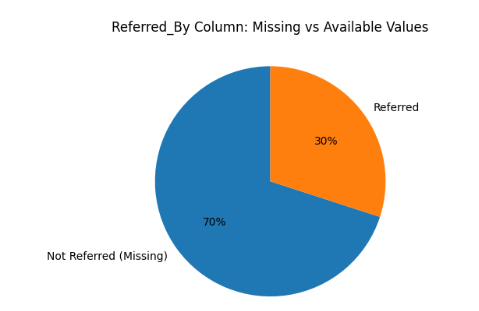



The pie chart shows that approximately **70% of the values in the `referred_by` column are missing**, indicating that the majority of customers were **not referred by anyone**. Only **30%** of customers have a recorded referrer.

Given the high proportion of missing values and the fact that these missing entries **cannot be logically inferred or imputed**, the `referred_by` column provides **limited analytical value**. Therefore, it is **reasonable to drop this column** during data preprocessing to improve **data quality** and **model robustness**.


---

In [29]:
# dropping the referred_by column
trip_riders_drivers_df.drop(columns=['referred_by'], inplace=True)

In [30]:
# Convert pickup and dropoff times safely, keeping timezone info
trip_riders_drivers_df['pickup_time'] = pd.to_datetime(trip_riders_drivers_df['pickup_time'], utc=True, errors='coerce')
trip_riders_drivers_df['dropoff_time'] = pd.to_datetime(trip_riders_drivers_df['dropoff_time'], utc=True, errors='coerce')
trip_riders_drivers_df['user_signup_date'] = pd.to_datetime(trip_riders_drivers_df['user_signup_date'], utc=True, errors='coerce')
trip_riders_drivers_df['driver_signup_date'] = pd.to_datetime(trip_riders_drivers_df['driver_signup_date'], utc=True, errors='coerce')
trip_riders_drivers_df['last_active'] = pd.to_datetime(trip_riders_drivers_df['last_active'], utc=True, errors='coerce')
trip_riders_drivers_df['age'] = trip_riders_drivers_df['age'].astype(int)


# Check the datatypes
print(trip_riders_drivers_df['pickup_time'].dtype)
print(trip_riders_drivers_df['dropoff_time'].dtype)
print(trip_riders_drivers_df['user_signup_date'].dtype)
print(trip_riders_drivers_df['driver_signup_date'].dtype)
print(trip_riders_drivers_df['age'].dtype)
print(trip_riders_drivers_df['churn_prob'].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]
int32
float64


In [31]:
# checking for irregularities in categorical variables
categorical_columns = trip_riders_drivers_df.select_dtypes(include=['object']).columns
categorical_columns

Index(['trip_id', 'user_id', 'driver_id', 'payment_type', 'weather',
       'loyalty_status', 'vehicle_type', 'city'],
      dtype='object')

In [32]:
cat_columns = ['payment_type', 'weather', 'loyalty_status', 'vehicle_type', 'city']
for col in cat_columns:
    print(col)
    print(trip_riders_drivers_df[col].unique())
    print()

payment_type
['Mobile Money' 'Card' 'Cash']

weather
['Cloudy' 'Sunny' 'Rainy' 'Foggy']

loyalty_status
['Silver' 'Bronze' 'Gold' 'Platinum']

vehicle_type
['SUV' 'Sedan' 'Motorcycle' 'Luxury']

city
['Cairo' 'Nairobi' 'Lagos']



In [33]:
trip_riders_drivers_df.head(2)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,user_signup_date,age,rating_by_driver,churn_prob,rating_by_rider,vehicle_type,driver_signup_date,last_active,city,acceptance_rate
0,T090716,R00102,D00000,5.07,1.0,0.00,Mobile Money,2025-03-14 08:29:08+00:00,2025-03-14 09:08:08+00:00,30.013226,...,2023-11-01 00:00:00+00:00,37,4.4,0.411712,3.1,SUV,2025-01-20 00:00:00+00:00,2025-01-06 18:23:09.312275+00:00,Cairo,0.679555
1,T113266,R01412,D00000,19.69,1.0,0.44,Mobile Money,2025-03-04 08:23:47+00:00,2025-03-04 09:10:47+00:00,30.131991,...,2024-05-23 00:00:00+00:00,24,4.6,0.196812,3.1,SUV,2025-01-20 00:00:00+00:00,2025-01-06 18:23:09.312275+00:00,Cairo,0.679555


#### **Cleaning the customer signup dates:** Cleaning and adjusting the inconsistency where a user's first recorded trip appears before their official signup date.

In [34]:
# Finding earliest trips for each user
earliest_user_trips = trip_riders_drivers_df.groupby('user_id')['pickup_time'].min().reset_index()
earliest_user_trips.columns = ['user_id', 'first_trip_recorded']   # replacing pickup_time with first_trip_recorded

# Merging this info back to see it alongside the signup date
# Looking at unique users for the explanation
user_dates = trip_riders_drivers_df[['user_id', 'user_signup_date']].drop_duplicates().merge(earliest_user_trips, on='user_id')

user_dates['user_adjusted_signup_date'] = user_dates[['user_signup_date', 'first_trip_recorded']].min(axis=1)   # Applying the "Simple Fix" logic by using the minimum of the two

# Flag rows where a change happened
user_dates['was_adjusted_for_users'] = user_dates['user_adjusted_signup_date'] < user_dates['user_signup_date']

# Showing the results for the breakdown
print("Total Unique Users:", len(user_dates))
print("Users requiring adjustment:", user_dates['was_adjusted_for_users'].sum())
user_dates.head(2)

Total Unique Users: 10000
Users requiring adjustment: 4717


,user_id,user_signup_date,first_trip_recorded,user_adjusted_signup_date,was_adjusted_for_users
0,R00102,2023-11-01 00:00:00+00:00,2024-05-03 22:40:21+00:00,2023-11-01 00:00:00+00:00,False
1,R01412,2024-05-23 00:00:00+00:00,2024-05-02 17:33:32+00:00,2024-05-02 17:33:32+00:00,True


In [35]:
trip_riders_drivers_df = trip_riders_drivers_df.merge(
    user_dates[['user_id', 'user_adjusted_signup_date']],
    on='user_id',
    how='left'
)

trip_riders_drivers_df['user_signup_date'] = trip_riders_drivers_df['user_adjusted_signup_date']
trip_riders_drivers_df.drop(columns=['user_adjusted_signup_date'], inplace=True)  # dropping the 'adjusted_signup_date' column

In [36]:
trip_riders_drivers_df[['user_signup_date', 'pickup_time']].head().reset_index(drop=True)

,user_signup_date,pickup_time
0,2023-11-01 00:00:00+00:00,2025-03-14 08:29:08+00:00
1,2024-05-02 17:33:32+00:00,2025-03-04 08:23:47+00:00
2,2024-05-15 15:06:22+00:00,2025-03-09 15:33:44+00:00
3,2023-08-29 00:00:00+00:00,2024-07-20 16:57:17+00:00
4,2023-06-01 00:00:00+00:00,2024-05-29 12:09:12+00:00


In [37]:
trip_riders_drivers_df['pickup_time'].dtype

datetime64[ns, UTC]

In [38]:
trip_riders_drivers_df['dropoff_date'] = trip_riders_drivers_df['pickup_time'].dt.date                              # Step 2: Extract the date part
trip_riders_drivers_df['dropoff_day'] = trip_riders_drivers_df['pickup_time'].dt.day_name()                         # Step 4: Extract the day of the week
trip_riders_drivers_df['dropoff_date'] = pd.to_datetime(trip_riders_drivers_df['dropoff_date'])

trip_riders_drivers_df.shape

(200000, 27)

#

#### **Applying the same approach to correct the drivers sign up date to adjust the inconsistency where a driver's first recorded trip appears before their official signup date.**

In [39]:
# Finding earliest trips for each driver
earliest_driver_trips = trip_riders_drivers_df.groupby('driver_id')['pickup_time'].min().reset_index()
earliest_driver_trips.columns = ['driver_id', 'first_trip_recorded']   # replacing pickup_time with first_trip_recorded

# Merging this info back to see it alongside the signup date
# Looking at unique drivers for the explanation
driver_dates = trip_riders_drivers_df[['driver_id', 'driver_signup_date']].drop_duplicates().merge(earliest_driver_trips, on='driver_id')
driver_dates['driver_adjusted_signup_date'] = driver_dates[['driver_signup_date', 'first_trip_recorded']].min(axis=1)    # Applying the "Simple Fix" logic by using the minimum of the two
driver_dates['was_adjusted_for_drivers'] = driver_dates['driver_adjusted_signup_date'] < driver_dates['driver_signup_date']              # Flag rows where a change happened

# Showing the results for the breakdown
print("Total Unique Users:", len(driver_dates))
print("Users requiring adjustment:", driver_dates['was_adjusted_for_drivers'].sum())
driver_dates.head(2)



Total Unique Users: 5000
Users requiring adjustment: 1635


,driver_id,driver_signup_date,first_trip_recorded,driver_adjusted_signup_date,was_adjusted_for_drivers
0,D00000,2025-01-20 00:00:00+00:00,2024-05-17 05:10:54+00:00,2024-05-17 05:10:54+00:00,True
1,D00001,2023-03-27 00:00:00+00:00,2024-04-29 06:40:21+00:00,2023-03-27 00:00:00+00:00,False


In [40]:
trip_riders_drivers_df = trip_riders_drivers_df.merge(
    driver_dates[['driver_id', 'driver_adjusted_signup_date']],
    on='driver_id',
    how='left'
)

trip_riders_drivers_df['driver_signup_date'] = trip_riders_drivers_df['driver_adjusted_signup_date']
trip_riders_drivers_df.drop(columns=['driver_adjusted_signup_date'], inplace=True)  # dropping the 'adjusted_signup_date' column

**feature engineered with 'trip_duration_mins'**

In [41]:
trip_riders_drivers_df['trip_duration_mins'] = (trip_riders_drivers_df['dropoff_time'] - trip_riders_drivers_df['pickup_time']).dt.total_seconds() / 60
trip_riders_drivers_df['trip_duration_mins'] = trip_riders_drivers_df['trip_duration_mins'].astype(int)
trip_riders_drivers_df['trip_duration_mins'].head(3).reset_index(drop=True)

0    39
1    47
2    48
Name: trip_duration_mins, dtype: int32

In [42]:
trip_riders_drivers_df[trip_riders_drivers_df['trip_duration_mins'] <= 0]      # this shows that all trips were completed

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,churn_prob,rating_by_rider,vehicle_type,driver_signup_date,last_active,city,acceptance_rate,dropoff_date,dropoff_day,trip_duration_mins


In [43]:
trip_riders_drivers_df['user_signup_date'].isna().sum()

0

**'rider_age_group' feature engineered**

In [44]:
def age_group(age):
    if age <= 24:
        return 'Young Starters'
    elif age <= 34:
        return 'Early Career Adults'
    elif age <= 50:
        return 'Mid-Career Adults'
    elif age <= 64:
        return 'Late Career Adults'
    else:
        return 'Senior Citizens'


trip_riders_drivers_df['rider_age_group'] = trip_riders_drivers_df['age'].apply(age_group)
trip_riders_drivers_df[['age','rider_age_group']].head(3).reset_index(drop=True)

,age,rider_age_group
0,37,Mid-Career Adults
1,24,Young Starters
2,61,Late Career Adults


#

**`pickup_hour`, `pickup_period`, `pickup_day`, `pickup_month`, `pickup_season` and `pickup_year`: features engineered**

In [45]:
trip_riders_drivers_df['pickup_hour'] = trip_riders_drivers_df['pickup_time'].dt.hour
trip_riders_drivers_df['pickup_date'] = trip_riders_drivers_df['pickup_time'].dt.date
trip_riders_drivers_df['pickup_day'] = trip_riders_drivers_df['pickup_time'].dt.day_name()
trip_riders_drivers_df['pickup_month'] = trip_riders_drivers_df['pickup_time'].dt.month_name()
trip_riders_drivers_df['pickup_year'] = trip_riders_drivers_df['pickup_time'].dt.year

def pickup_period(hour):
    if 0 <= hour < 4:
        return 'Late Night'
    elif 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

trip_riders_drivers_df['pickup_period'] = trip_riders_drivers_df['pickup_time'].apply(lambda x: pickup_period(x.hour))

# Define seasons
season_map = { 'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
              'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
               'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
               'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn' }

trip_riders_drivers_df['pickup_season'] = trip_riders_drivers_df['pickup_month'].map(season_map)    # Create a new pickup_season column

trip_riders_drivers_df[['pickup_hour','pickup_period','pickup_day','pickup_month','pickup_season', 'pickup_year']].head(3).reset_index(drop=True)

,pickup_hour,pickup_period,pickup_day,pickup_month,pickup_season,pickup_year
0,8,Morning,Friday,March,Spring,2025
1,8,Morning,Tuesday,March,Spring,2025
2,15,Afternoon,Sunday,March,Spring,2025


#

In [46]:
trip_riders_drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   trip_id             200000 non-null  object             
 1   user_id             200000 non-null  object             
 2   driver_id           200000 non-null  object             
 3   fare                200000 non-null  float64            
 4   surge_multiplier    200000 non-null  float64            
 5   tip                 200000 non-null  float64            
 6   payment_type        200000 non-null  object             
 7   pickup_time         200000 non-null  datetime64[ns, UTC]
 8   dropoff_time        200000 non-null  datetime64[ns, UTC]
 9   pickup_lat          200000 non-null  float64            
 10  pickup_lng          200000 non-null  float64            
 11  dropoff_lat         200000 non-null  float64            
 12  dropoff_lng     

In [54]:
trip_riders_drivers_df.to_csv('C:/Users/User/Desktop/ridewise/data/processed_data/trip_riders_drivers_df.csv', index=False)

In [ ]:
trip_riders_drivers_df.columns

In [ ]:
sessions_df.head()

In [ ]:
trip_riders_drivers_df.describe(include='all').transpose()